In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


# Train on a custom dataset

In [2]:
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

In [4]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [20]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [7]:
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


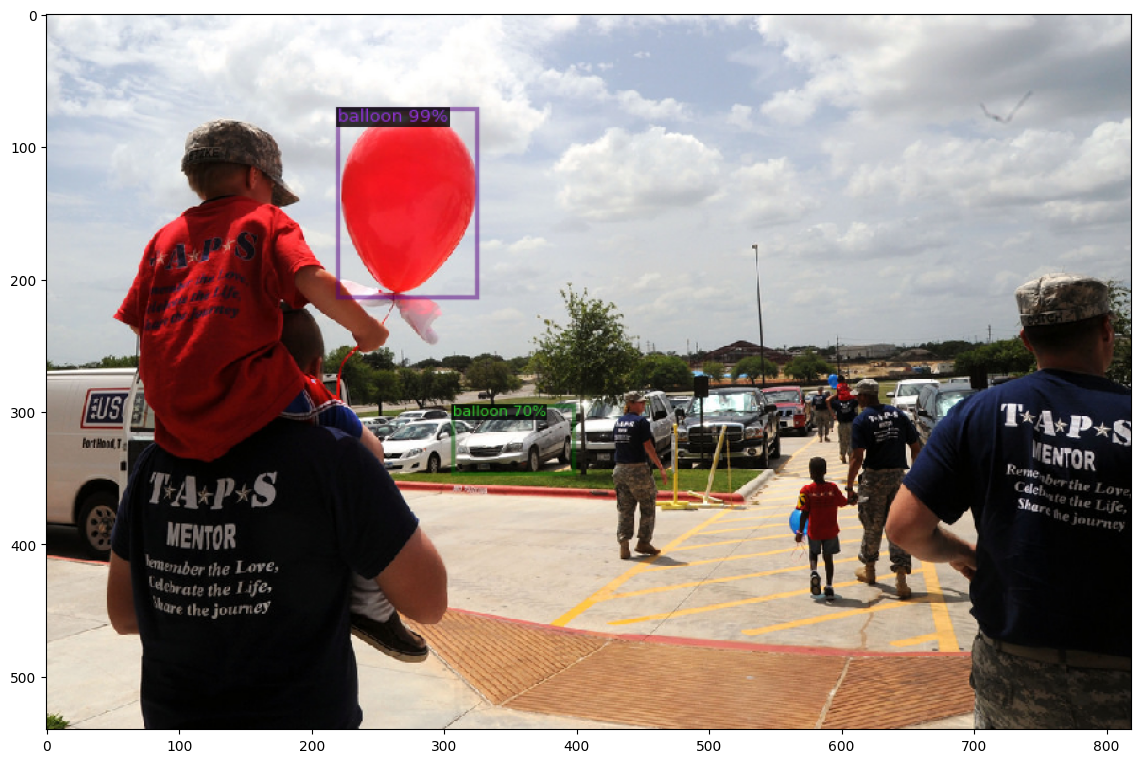

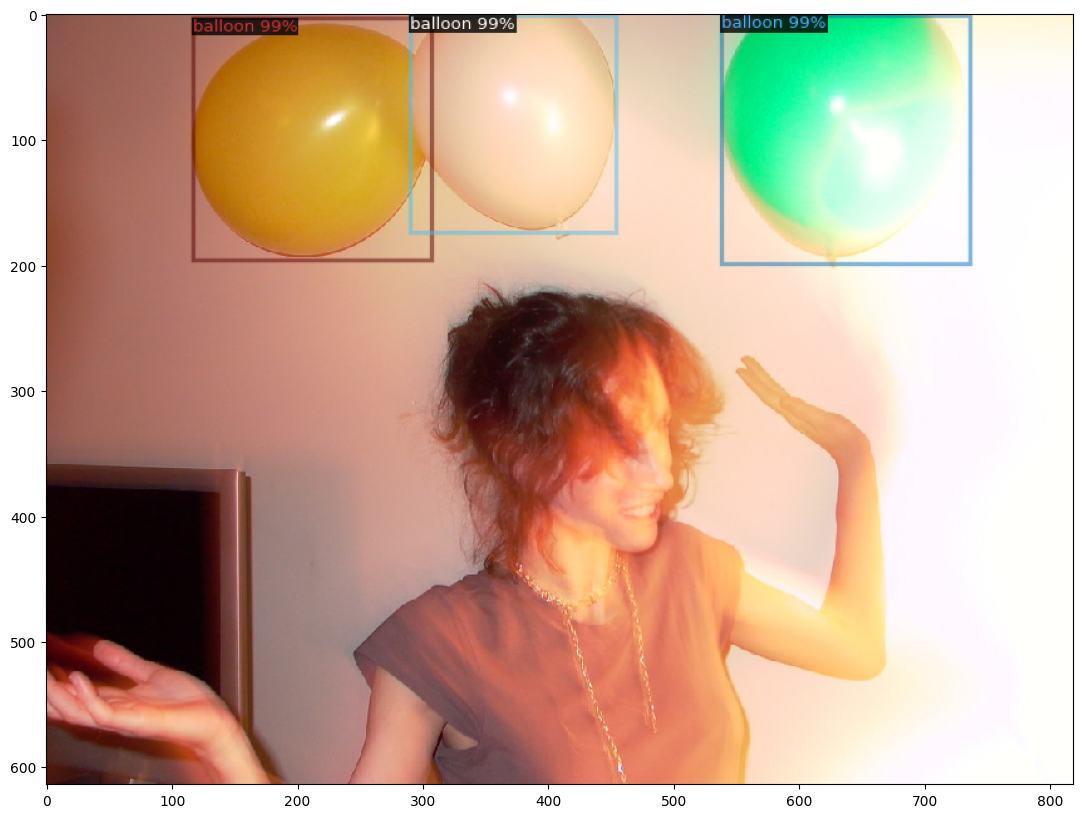

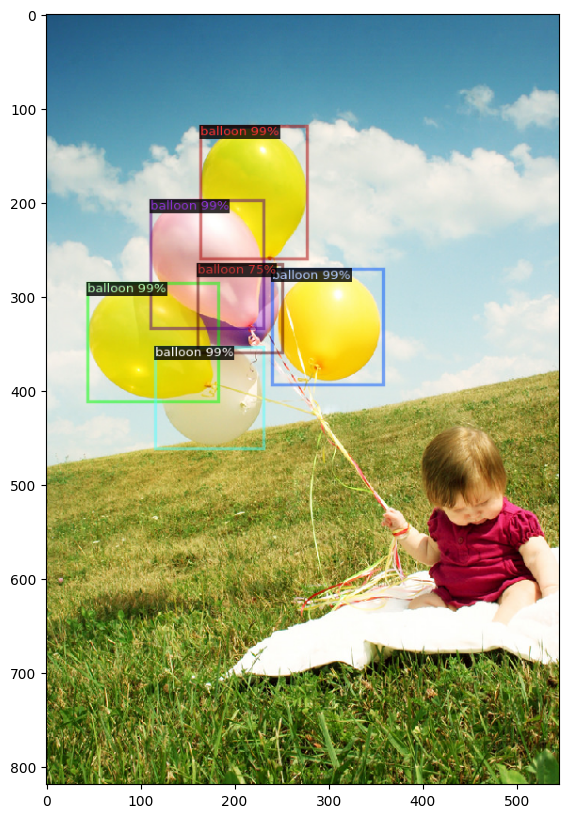

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[07/09 19:12:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/09 19:12:58 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[07/09 19:12:58 d2.data.common]: Serialized dataset takes 0.04 MiB
[07/09 19:12:58 d2.evaluation.evaluator]: Start inference on 13 batches
[07/09 19:13:00 d2.evaluation.evaluator]: Inference done 11/13. Dataloading: 0.0010 s/iter. Inference: 0.1685 s/iter. Eval: 0.0002 s/iter. Total: 0.1696 s/iter. ETA=0:00:00
[07/09 19:13:00 d2.evaluation.evaluator]: Total inference time: 0:00:01.409308 (0.176164 s / iter per device, on 1 devices)
[07/09 19:13:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.167796 s / iter per device, on 1 devices)
[07/09 19:13:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/09 19:13:00 d2.evaluation.coco_evaluation]: Saving results to

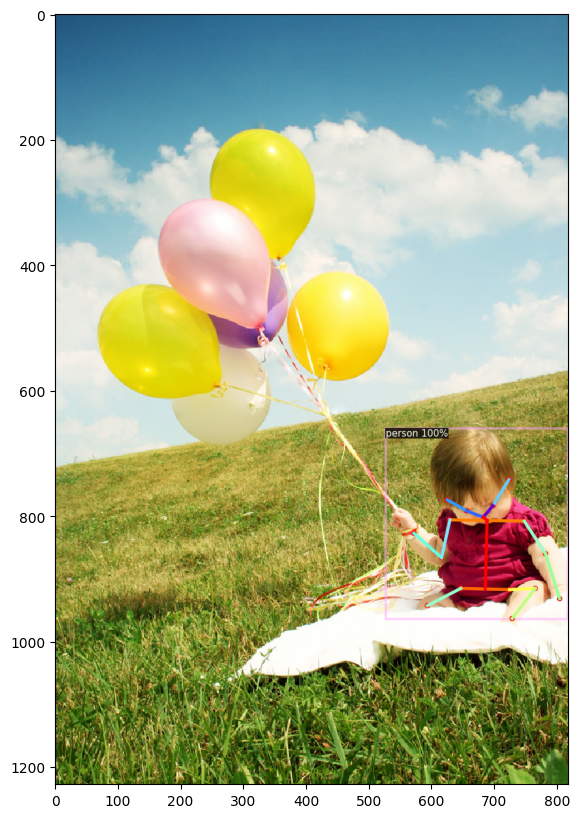

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

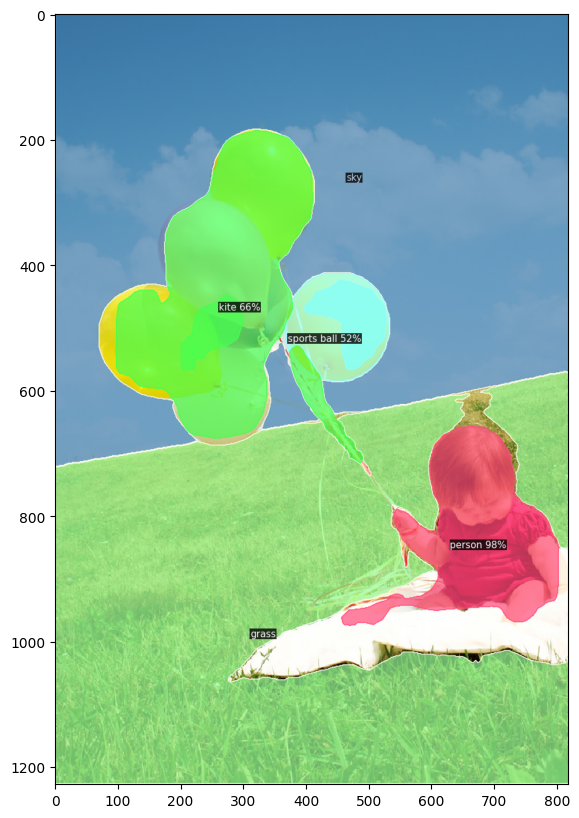

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()